In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
from pylift.eval import UpliftEval

In [3]:
# Read in sampled data (5% of original data)
sampled_df = pd.read_csv("../criteo_data/sampled_df.csv", index_col = 0)

In [4]:
sampled_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,visit,exposure,conversion
3028168,22.478962,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
1889203,21.842794,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
2536146,26.168970,10.059654,8.214383,4.679882,10.280525,4.115453,-9.864621,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
9491608,22.212511,10.059654,8.214383,4.679882,10.280525,4.115453,-9.404879,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
4931957,25.685535,10.059654,8.214383,4.679882,10.280525,4.115453,-7.011752,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [5]:
# Split sampled data into train and test
# Visit as outcome
train_X, test_X, train_y, test_y = train_test_split(sampled_df.drop(columns = ["visit", "exposure", "conversion"]), sampled_df[["visit"]], test_size = 0.2, random_state = 0)

In [6]:
train_X.treatment.mean()

0.8500565109159061

In [7]:
test_X.treatment.mean()

0.8497739563363759

As shown, the __train and test data has a similar distribution of treatment to control ratio with about 85% of the population with Treatment = 1__. 

For this notebook walkthrough, __we will only be using "visit" outcome as the binary result of interest__. Note that this can be extended to "conversion" as well. 

## Meta Learners

Meta-Learners are basically frameworks that allow one to use any choice of ML models (linear models, ensembles, etc).

In this notebook, I will go through 3 types of Meta learners with a breakdown of the framework algorithm steps in code:
- S-Learner
- T-Learner
- X-Learner

Since one can use any ML model, I chose XGBoost Classifier with the default hyperparameters. In this walkthrough, I __avoided any hyperparameter tuning__ as I wanted to focus on the meta-learner algorithm breakdown, but one can always perform hyperparameter tuning with the typical cross-validation (preferably with stratified K-folds).
- The implicit assumption is that the training data sample and the test data sample is drawn from the same distribution such that cross-validation allows for model performance generalisation

The notebook will create the different meta-learners frameworks using Class objects, and each class object will have two main methods:
- __fit__: Training of the internal ML models. No hyperparameter tuning was performed in this simple example.
- __predict_tau__: Prediction of the CATE for each experimental unit's set of covariates X.

## Causal Inference Assumptions
As usual, since this is Causal Inference, we have to make the "Conditional Exchangeability/Unconfoundedness" assumption. This means that there are no unmeasured unconfounders, and that within various levels of X covariates, there is no non-causal association between T and Y. 

$$ Y^0, Y^1 \perp T | X$$

We also have to assume that X does not comprise of any descendants of T in the graphical model in order to avoid collider bias.

## Uplift Adjusted Qini Curve



With any gain/Qini curve chart, the population is first sorted by the __predicted individual treatment effect__ in decreasing order (Left to Right along the x-axis). As we increase the population fraction $\phi$, we calculate the uplift metric accordingly. Some of the metrics include:
- Cumulative Gain
- Qini
- Adjusted Qini

Given that our treatment ratio is about 85%, this means that for each population slice, we have a much higher proportion of treatment group compared to the control group, which might cause some imbalance in the gain calculation. For this notebook, in the y-axis, we use the Adjusted Qini metric which is based on the formula:

$$ Adjusted\ Qini(\phi) = \frac{\eta_{t,1}(\phi)}{N_t} - \frac{\eta_{c,1}(\phi)\eta_t(\phi)}{\eta_c(\phi)N_t}$$

Thus, there is a rationale to use the Adjusted Qini metric. This metric attempts to balance the weights of the calculated Qini value by __scaling the 2nd factor (control group gain proportion) such that it is an "equivalent gain" if the control group had the same population ratio as the treatment group__. For more details of the Adjusted Qini calculation, refer to [Pylift's documentation](https://pylift.readthedocs.io/en/latest/introduction.html#alternate-qini-style-curves)

The graph illustrates the impact of targeted treatment policies, where the experimental units that are most susceptible to have the highest treatment effect will have the highest increase in Qini metric and the metric will taper off as we increase the population fraction $\phi$ from left to right.

# S-Learner (Single Model)

S-Learner incorporates the Treatment variable as a part of the covariates and fits a single model. The CATE estimation workflow is based on the following:

$$
\begin{align}
\hat{\tau}(x) & = E[Y | X = x, T = 1] - E[Y|X=x, T=0] \\
 & = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)
\end{align}
$$

As per its namesake, it uses a Single model to model outcomes Y as a function of X and T concatenated inputs, where $ \hat{\mu} = M(Y \sim (X,T))$.

After the model fitting, we can proceed to calculate the CATE estimation for each row of X covariates. This is done by creating two inputs (toggling T = 1 or T = 0) and feeding them into the same trained S-model to generate the potential outcomes $Y^1$ and $Y^0$. The difference between $Y^1$ and $Y^0$ is the CATE estimation for each given experimental unit with features X.

In [20]:
class SLearner_xgb():
    
    def __init__(self):
        
        self.model = xgb.XGBClassifier(random_state = 0)
    
    def fit(self, train_X, train_y):
        
        # Use single model to train on concatenated input of covariates X and Treatment 
        self.model.fit(train_X, train_y)

    def predict_tau(self, data):
        
        data_copy = data.copy()
        
        # CATE tau = mu(X = x, T = 1) - mu(X=x, T = 0)
        # Predict proba on 2 classes so take proba of Class 1
        data_copy["tau"] = self.model.predict_proba(data.assign(treatment=1))[:,1] - self.model.predict_proba(data.assign(treatment = 0))[:,1]
        
        return data_copy[["tau"]]

In [21]:
slearner_object = SLearner_xgb()

In [22]:
slearner_object.fit(train_X, train_y)

/home/kfoofw/yes/envs/uplift_modelling/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kfoofw/yes/envs/uplift_modelling/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:41:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
# CATE calculation
train_S_tau = slearner_object.predict_tau(train_X)

test_S_tau = slearner_object.predict_tau(test_X)

In [26]:
train_S_tau

,tau
12117699,0.000008
10092685,0.001715
5316960,0.000472
4358609,0.000007
11215458,0.002297
...,...
12723981,0.000007
7485838,0.000036
5167236,0.000066
8939846,0.124677


In [27]:
test_S_tau

,tau
2969374,0.000007
8968646,0.000065
172865,0.000007
13959486,0.000575
6030234,-0.000030
...,...
5503902,0.000008
9601147,0.000431
13233178,0.007369
3962632,0.001992


With the S model, we can use it to predict the outcomes on the Test data set. Given that this is a non-simulated data set, the ground truth of actual individual treatment effect for each experimental unit is not known. Thus, the __uplift curve shown is based on the population sorting using the predicted outcome, but it may not be sorted correctly according to the ground truth (actual individual treatment effects)__.

<AxesSubplot:title={'center':'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

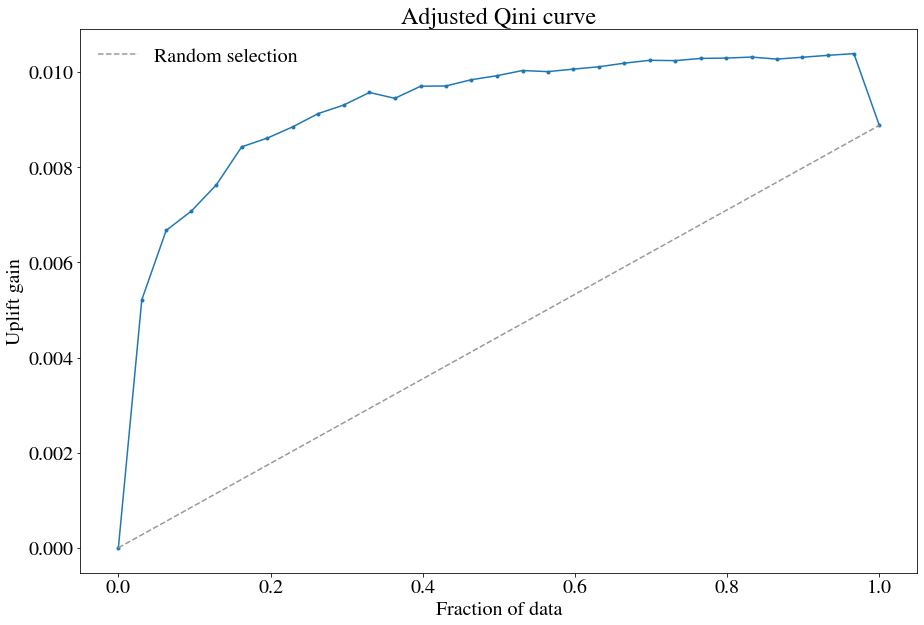

In [28]:
upev_S_train = UpliftEval(treatment = train_X["treatment"], 
                  outcome = train_y["visit"], 
                  prediction = train_S_tau["tau"], 
                  n_bins = 30)
upev_S_train.plot(plot_type='aqini')

<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

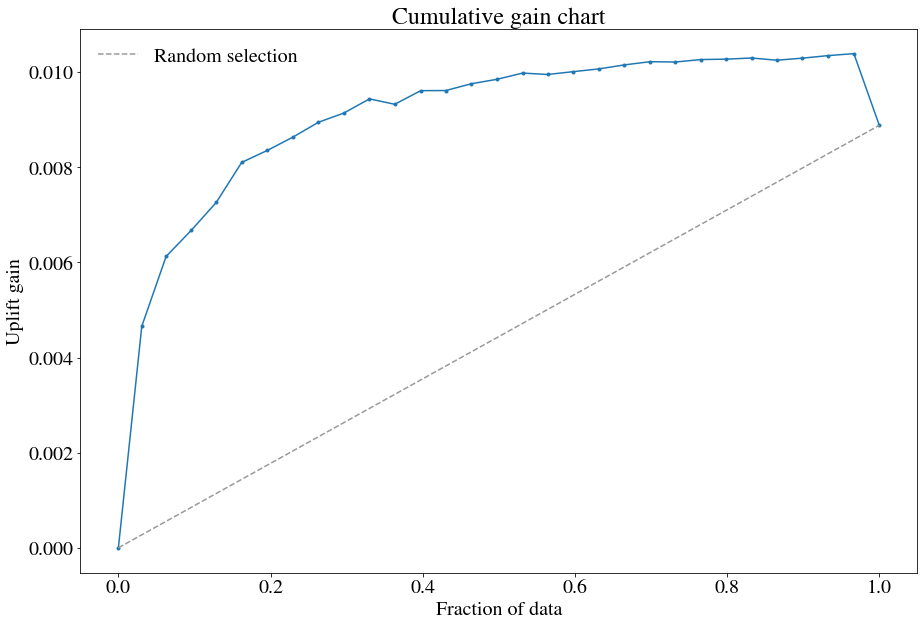

In [29]:
upev_S_train = UpliftEval(treatment = train_X["treatment"], 
                  outcome = train_y["visit"], 
                  prediction = train_S_tau["tau"], 
                  n_bins = 30)
upev_S_train.plot(plot_type='cgains')

<AxesSubplot:title={'center':'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

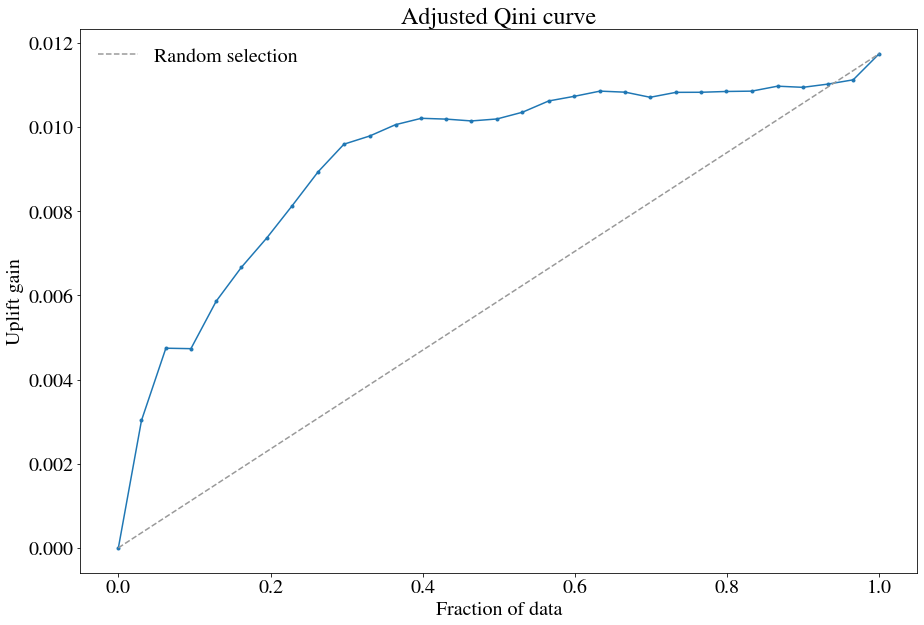

In [30]:
upev_S_test = UpliftEval(treatment = test_X["treatment"], 
                  outcome = test_y["visit"], 
                  prediction = test_S_tau["tau"], 
                  n_bins = 30)
upev_S_test.plot(plot_type='aqini')

<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

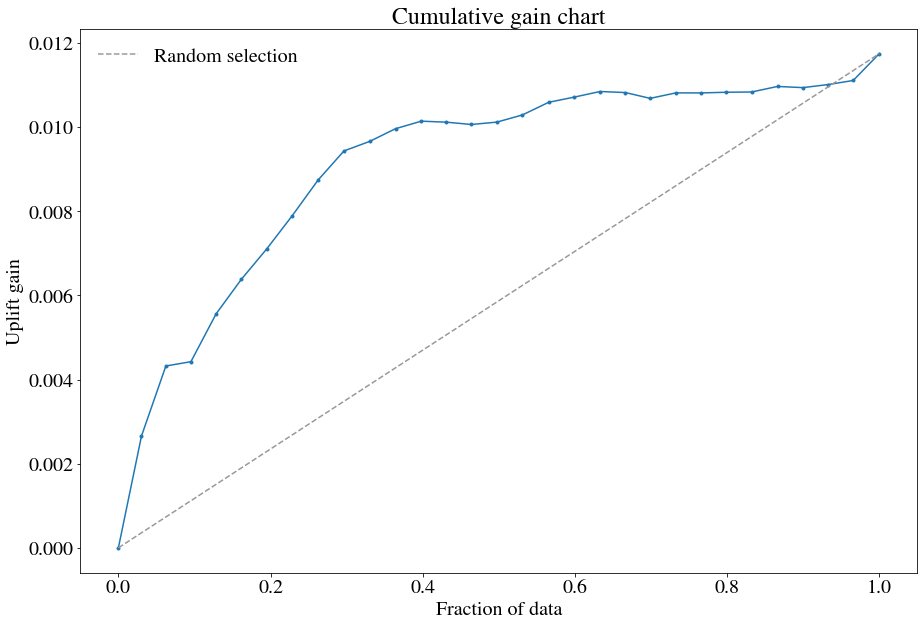

In [31]:
upev_S_test = UpliftEval(treatment = test_X["treatment"], 
                  outcome = test_y["visit"], 
                  prediction = test_S_tau["tau"], 
                  n_bins = 30)
upev_S_test.plot(plot_type='cgains')

Based on the plots, the S-Learner shows similar uplift between the train and test data set. This performance generalisation across the datasets can be attributed to the fact that __S only has a single internal model that was trained with all available data (this is a key crucial point for discussion in T-Learner and X-Learner)__. Thus, the S-Learner gives a reasonable performance as long as the train and test data have similar distributions.

# T-Learner (2 Models)

T-Learner creates 2 separate models for the estimation of outcomes (treatment outcome $Y_1$ based on the treatment group vs control outcome $Y_0$ for the control group). The CATE estimation workflow is based on the following:

$$
\begin{align}
\hat{\tau}(x) & = E[Y(1) - Y(0) | X = x] \\
 & = E[Y(1)|X=x] - E[Y(0) | X=x] \\ 
 & = \hat{\mu}_1(x) - \hat{\mu}_0(x)
\end{align}
$$

where $ \hat{\mu}_0 = M_0(Y^{T=0} \sim X^{T=0})$ and $ \hat{\mu}_1 = M_1(Y^{T=1} \sim X^{T=1})$ are the separate outcome models trained on the different grouped data.

In [32]:
class TLearner_xgb():
    
    def __init__(self):
        
        self.model_treatment = xgb.XGBClassifier(random_state = 0)
        self.model_control = xgb.XGBClassifier(random_state = 0)
    
    def fit(self, train_X, train_y):
        
        # Split data into Treatment (T =1) vs Control (T=0)
        train_X_control = train_X.query("treatment == 0")
        train_y_control = train_y[train_X["treatment"] == 0]

        train_X_treatment = train_X.query("treatment == 1")
        train_y_treatment = train_y[train_X["treatment"] == 1]
        
        # Use individual models M1 or M2 to train 
        self.model_control.fit(train_X_control.drop(columns = "treatment"), train_y_control)
        self.model_treatment.fit(train_X_treatment.drop(columns = "treatment"), train_y_treatment)

    def predict_tau(self, data):
        
        data_copy = data.copy()
        
        # Predict proba on 2 classes so take proba of Class 1 for each separate model
        data_copy["tau"] = self.model_treatment.predict_proba(data.drop(columns = "treatment"))[:,1] - self.model_control.predict_proba(data.drop(columns = "treatment"))[:,1]
        
        return data_copy[["tau"]]

In [33]:
tlearner_object = TLearner_xgb()

In [34]:
tlearner_object.fit(train_X, train_y)

/home/kfoofw/yes/envs/uplift_modelling/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kfoofw/yes/envs/uplift_modelling/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:49:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:49:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
train_T_tau = tlearner_object.predict_tau(train_X)

test_T_tau = tlearner_object.predict_tau(test_X)

In [36]:
train_T_tau

,tau
12117699,0.001027
10092685,0.002225
5316960,0.001709
4358609,0.000600
11215458,0.004738
...,...
12723981,0.000244
7485838,-0.001224
5167236,0.003505
8939846,0.214677


In [38]:
test_T_tau

,tau
2969374,0.000241
8968646,0.004485
172865,0.000604
13959486,0.000111
6030234,-0.010689
...,...
5503902,0.000615
9601147,0.019280
13233178,0.067317
3962632,0.021726


<AxesSubplot:title={'center':'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

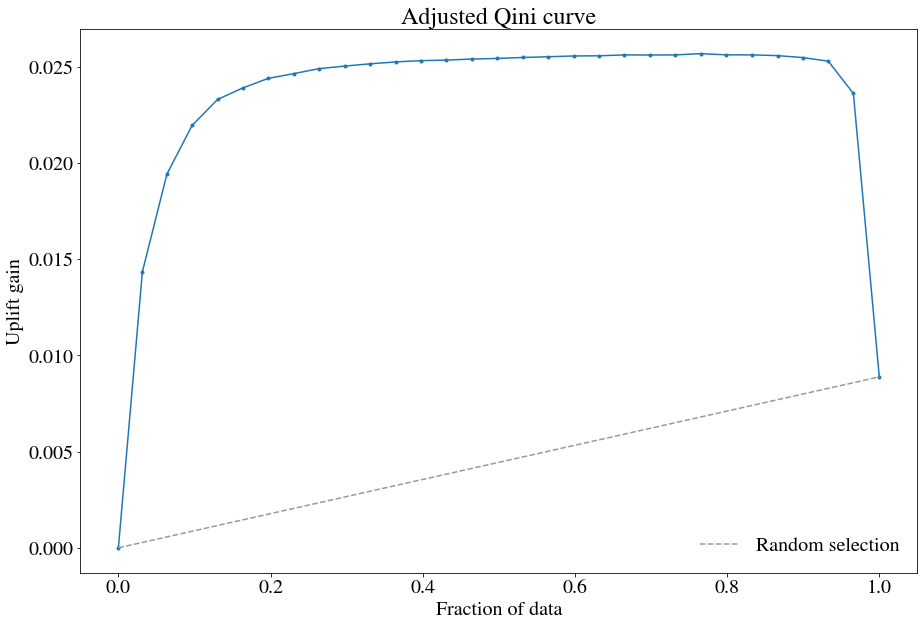

In [40]:
upev_T_train = UpliftEval(treatment = train_X["treatment"], 
                  outcome = train_y["visit"], 
                  prediction = train_T_tau["tau"], 
                  n_bins = 30)
upev_T_train.plot(plot_type='aqini')

<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

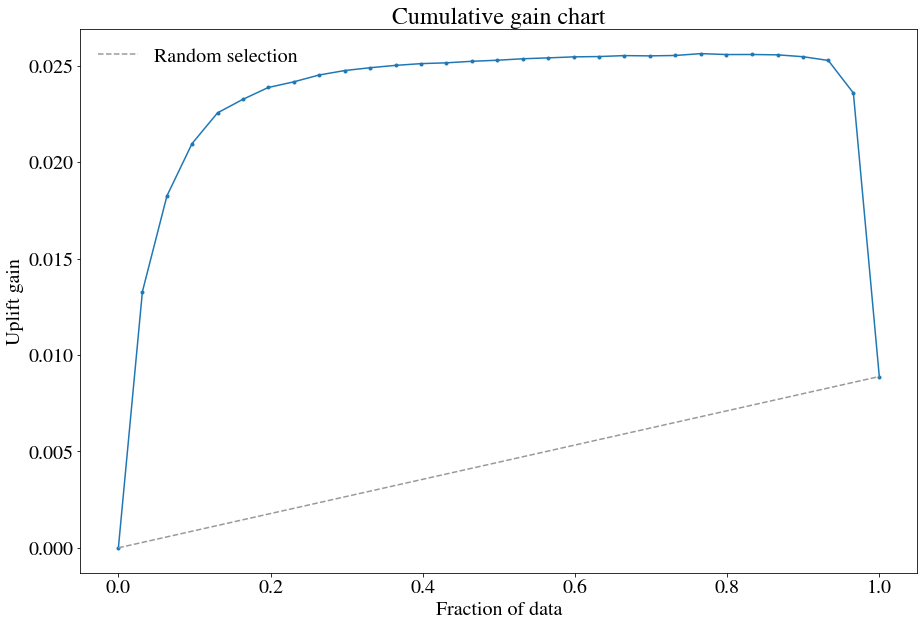

In [41]:
upev_T_train = UpliftEval(treatment = train_X["treatment"], 
                  outcome = train_y["visit"], 
                  prediction = train_T_tau["tau"], 
                  n_bins = 30)
upev_T_train.plot(plot_type='cgains')

<AxesSubplot:title={'center':'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

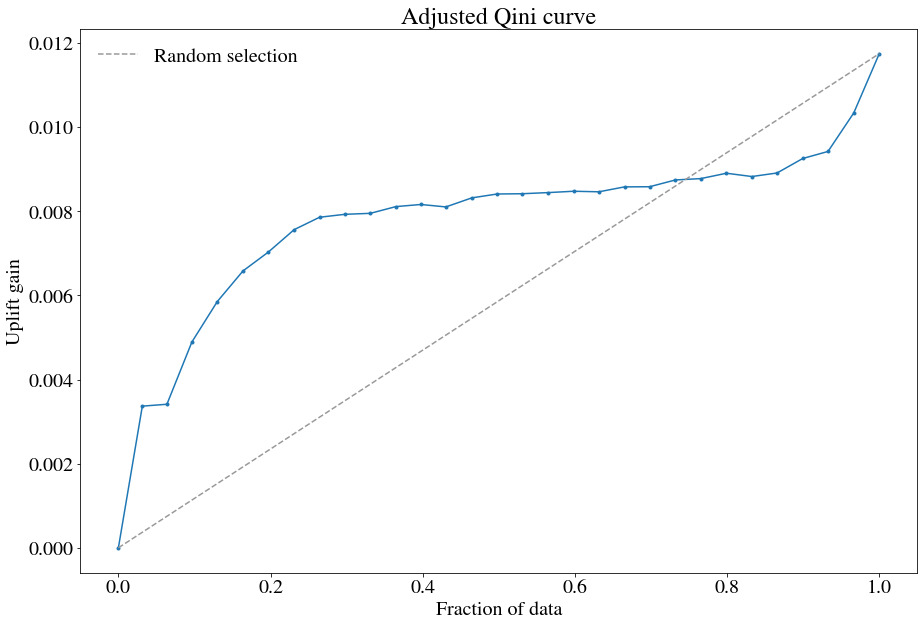

In [42]:
upev_T_test = UpliftEval(treatment = test_X["treatment"], 
                  outcome = test_y["visit"], 
                  prediction = test_T_tau["tau"], 
                  n_bins = 30)
upev_T_test.plot(plot_type='aqini')

<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

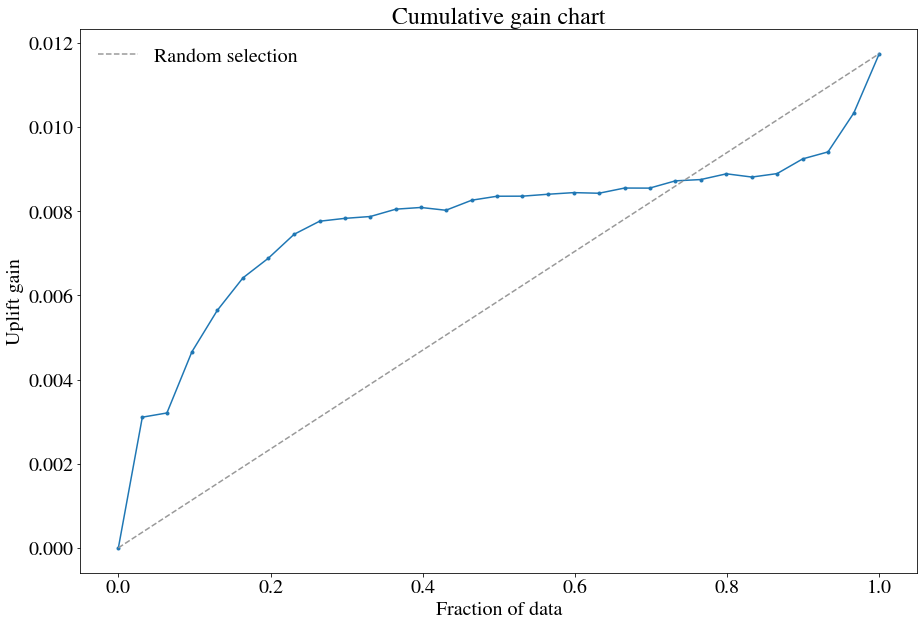

In [43]:
upev_T_test = UpliftEval(treatment = test_X["treatment"], 
                  outcome = test_y["visit"], 
                  prediction = test_T_tau["tau"], 
                  n_bins = 30)
upev_T_test.plot(plot_type='cgains')

As shown, without any cross validation and hyperparameter tuning for generalisation, the T-Learner seems to overfit the training data in its estimation of the CATE values. 
- My hypothesis for this phenomenon is that __85% of the data is for the treatment group, and only 15% of the data is for the control group__. 
- Thus, the internal models have separate amounts of available data for training, and I would presume the Control group would not be as "accurate" compared to the Treatment group.

The resultant uplift curve on the test data set shows a similar uplift model that is similar to what was shown in the S-Learner model.

I would also think that cross validation with hyperparameter tuning will improve the T-Learner's internal model's performance generalisation, and consequently improve the CATE estimation.

# X-Learner

With the T-Learner, the data is split accordingly to the treatment and control group, and subsequently used for training the corresponding outcome models $M_0$ or $M_1$. A glaring issue with this is that the data is not used efficiently (treatment data is only used for treatment group outcome modelling while control data is only used for control group outcome modelling).

The X-Learner aims to tackle this data inefficiency via a two stage approach. It comprises of two stages:
- __1st Stage__: Same as T-Learner where it creates the separate outcome models $\hat{\mu}_0$ or $\hat{\mu}_1$

$$
\begin{align}
\hat{\tau}(x) & = E[Y(1) - Y(0) | X = x] \\
 & = E[Y(1)|X=x] - E[Y(0) | X=x] \\ 
 & = \hat{\mu}_1(x) - \hat{\mu}_0(x),\ where \\
\hat{\mu}_0 & = M_1(Y^{T=0} \sim X^{T=0}) \\
\hat{\mu}_1 & = M_2(Y^{T=1} \sim X^{T=1}) \\
\end{align}
$$

- __2nd Stage (a)__: Utilises the outcome models to provide the counterfactual outcomes for the counterpart group. For the control group, the counterfactual outcome is $Y^{T=1} = \hat{\mu}_1(X^{T=0})$, and vice versa for the control group. Thereafter, the estimated Conditional Average Treatment effect on Treated (CATT) $\hat{D}^{T=1}$ and Conditional Average Treatment effect on Control (CATC) $\hat{D}^{T=0}$ are calculated.

$$ 
\hat{D}^{T=1} = Y^{T=1} - \hat{\mu}_0(X^{T=1}) \\
\hat{D}^{T=0} = \hat{\mu}_1(X^{T=0}) - Y^{T=0} 
$$

- __2nd Stage (b)__: Fit two separate models (one for CATT with $X^{T=1}$ and one for CATC with $X^{T=0}$) . Subsequently, combine them with a weighted average based on a function $g(x)$ to calculate the CATE $\hat{\tau}$. Note that $g(x)$ can be any function but it typically tends to be the propensity scoring model based on $M_{propensity}(T \sim X)$.


$$
\begin{align}
\hat{\tau_0} & = M_3(\hat{D}^{T=0} \sim X^{T=0}) \\
\hat{\tau_1} & = M_4(\hat{D}^{T=1} \sim X^{T=1}) \\
\hat{\tau} & = g(x) \hat{\tau_0}(x) + (1 - g(x)) \hat{\tau_1}(x)
\end{align}
$$

As shown, the outcome modelling in the 1st stage is used for the counterfactual calculation of the CATT or CATC. Thus the data that was segregated in the 1st stage outcome modelling is incorporated implicitly in the 2nd stage CATE modelling, which improves the data efficiency.

$M_1, M_2, M_3, M_4$ can be any ML models, but in the following example, we will use XGBoost with the default settings.
- Note that I have also used XGBoost (default hyperparameters) for the propensity scoring model, but one can use other appropriate models such as Logistic Regression to model $ T \sim X$

In [44]:
class XLearner_xgboost():
    
    def __init__(self):
        # 1st stage (Classifier)
        self.model_control_1 = xgb.XGBClassifier(random_state = 0)
        self.model_treatment_1 = xgb.XGBClassifier(random_state = 0)
        
        # 2nd Stage (Regressor as it is training on the predict_proba output of Stage 1)
        self.model_control_2 = xgb.XGBRegressor(random_state = 0)
        self.model_treatment_2 = xgb.XGBRegressor(random_state = 0)
        
        # Propensity Model
        self.propensity_score_model = xgb.XGBClassifier(random_state = 0)
        
    def fit(self, train_X, train_y):
        
        # Create copy of training data for manipulation
        train_X_copy = train_X.copy()

        # Data splitting
        train_X_control = train_X.query("treatment == 0")
        train_y_control = train_y[train_X["treatment"] == 0]

        train_X_treatment = train_X.query("treatment == 1")
        train_y_treatment = train_y[train_X["treatment"] == 1]

        # Stage 1 models to model
        self.model_control_1.fit(train_X_control.drop(columns = "treatment"), train_y_control)
        self.model_treatment_1.fit(train_X_treatment.drop(columns = "treatment"), train_y_treatment)

        # Use Stage 1 models to create counterfactual values to be used for calculation of D variable for Stage 2
        train_X_copy["X_model_treatment_predict"] = self.model_treatment_1.predict_proba(train_X.drop(columns = "treatment"))[:,1]
        train_X_copy["X_model_control_predict"] = self.model_control_1.predict_proba(train_X.drop(columns = "treatment"))[:,1]

        # CATE calculation for both Treated and Control Group. CATE is now a continuous variable
        train_X_copy["D"] = np.where(train_X_copy["treatment"]==1,
                                    train_y["visit"] - train_X_copy["X_model_control_predict"], # Y_T=1 - mu_0(X_T=1)
                                    train_X_copy["X_model_treatment_predict"] - train_y["visit"] # mu_1(X_T=0) - Y_T=0
                                   )

        # Stage 2 Models to model D ~ X
        self.model_control_2.fit(train_X.query("treatment == 0").drop(columns = ["treatment"]), train_X_copy.query("treatment == 0")["D"])
        self.model_treatment_2.fit(train_X.query("treatment == 1").drop(columns = ["treatment"]), train_X_copy.query("treatment == 1")["D"])

        # Propensity scoring using train data
        self.propensity_score_model.fit(train_X.drop(columns = "treatment"), train_X["treatment"])
    
    def predict_tau(self, X_data):
        '''
        Predicting CATE for covariates X (regardless of treatment)
        
        '''
        X_data_copy = X_data.copy()
        
        # Corrected
        X_data_copy["propensity_score"] = self.propensity_score_model.predict_proba(X_data.drop(columns = "treatment"))[:,1]
        X_data_copy["tau_0"] = self.model_control_2.predict(X_data.drop(columns = "treatment"))
        X_data_copy["tau_1"] = self.model_treatment_2.predict(X_data.drop(columns = "treatment"))

        # CATE
        # tau = g(x) * tau_0(x) + (1 - g(x)) * tau_1(x)
        X_data_copy["tau"] = X_data_copy["propensity_score"] * X_data_copy["tau_0"] +  (1 - X_data_copy["propensity_score"]) * X_data_copy["tau_1"] 

        return X_data_copy[["tau"]]

In [45]:
xlearner_object = XLearner_xgboost()

In [46]:
xlearner_object.fit(train_X, train_y)

/home/kfoofw/yes/envs/uplift_modelling/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kfoofw/yes/envs/uplift_modelling/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:18:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:18:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kfoofw/yes/envs/uplift_modelling/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
train_X_tau = xlearner_object.predict_tau(train_X)

test_X_tau = xlearner_object.predict_tau(test_X)

<AxesSubplot:title={'center':'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

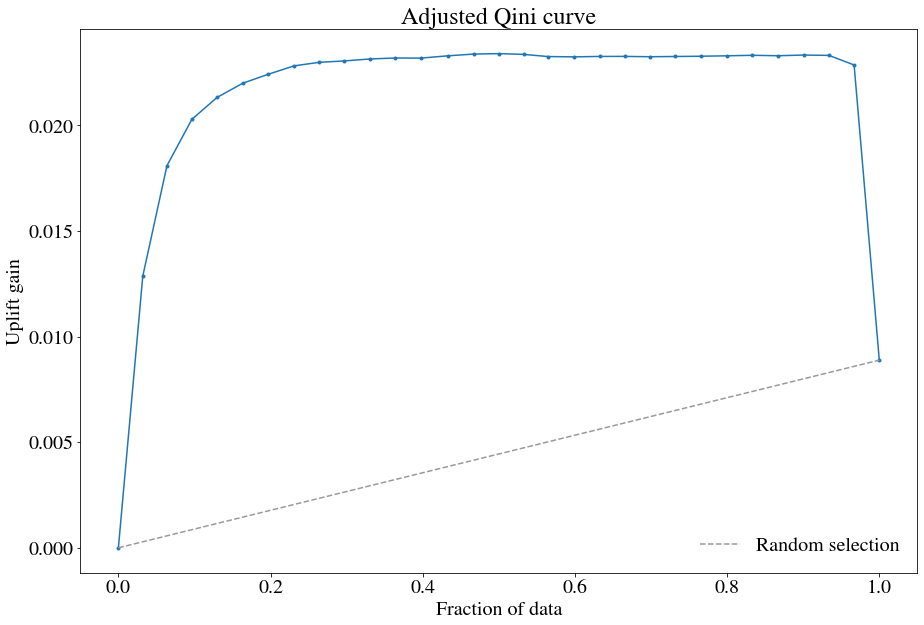

In [48]:
upev_X_train = UpliftEval(treatment = train_X["treatment"], 
                  outcome = train_y["visit"], 
                  prediction = train_X_tau["tau"], 
                  n_bins = 30)
upev_X_train.plot(plot_type='aqini')

<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

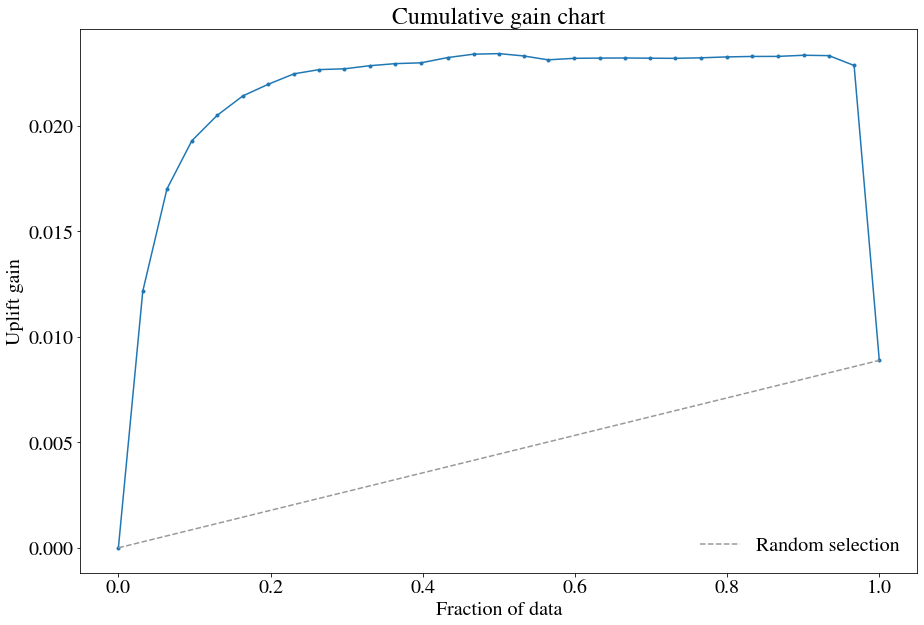

In [49]:
upev_X_train = UpliftEval(treatment = train_X["treatment"], 
                  outcome = train_y["visit"], 
                  prediction = train_X_tau["tau"], 
                  n_bins = 30)
upev_X_train.plot(plot_type='cgains')

<AxesSubplot:title={'center':'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

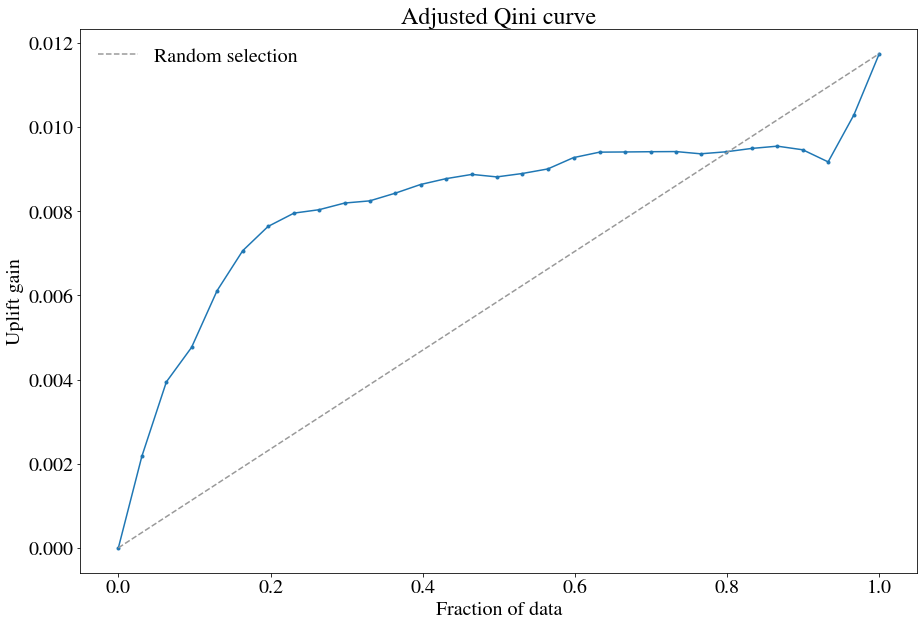

In [50]:
upev_X_test = UpliftEval(treatment = test_X["treatment"], 
                  outcome = test_y["visit"], 
                  prediction = test_X_tau["tau"], 
                  n_bins = 30)
upev_X_test.plot(plot_type='aqini')

<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

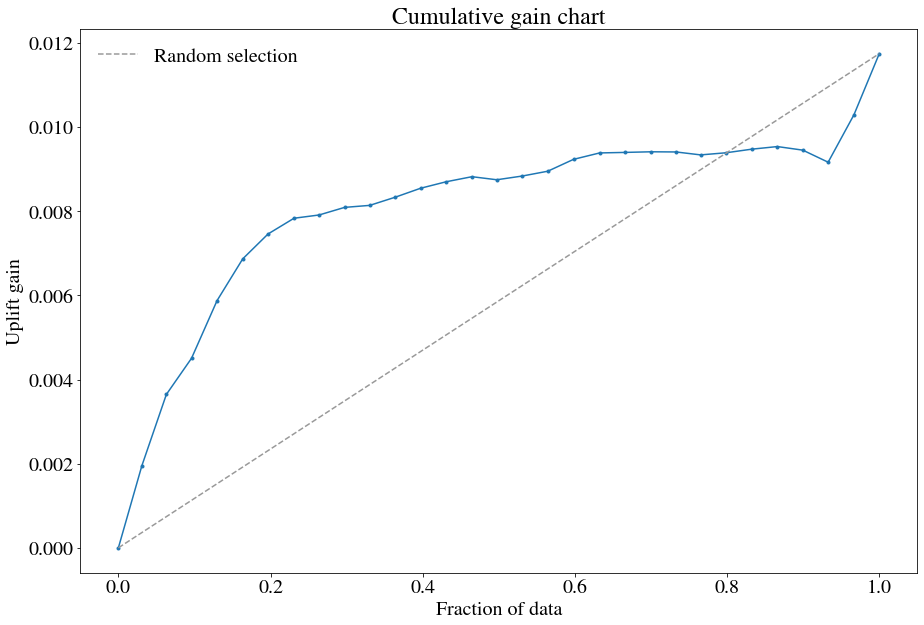

In [51]:
upev_X_test = UpliftEval(treatment = test_X["treatment"], 
                  outcome = test_y["visit"], 
                  prediction = test_X_tau["tau"], 
                  n_bins = 30)
upev_X_test.plot(plot_type='cgains')

The X-Learner shows a similar phenomenon to what we saw in the T-Learner, where without any cross validation and hyperparameter tuning for generalisation, the submodels seems to overfit the training data in its estimation of the CATE values. Likewise, the proposed hypothesis is due to the imbalance of the treatment vs control data, causing the Control group submodel to not be as "accurate".

The resultant uplift curve on the test data set shows a more muted uplift curve compared to the S or T-Learner frameworks. One postulation is that the X-Learner framework itself is __a stacked model framework which comes with a higher level of complexity__. However, this comes at a disadvantage where __any error in the lower level (Stage 1) can propagate to the higher level (Stage 2)__. Since the Stage 1 Control submodel was not as accurate given its more limited training, the errors are carried forward into the Stage 2 modelling. Thus, it is probably essential to perform cross-validation to tune the hyperparameters so that the CATE estimation has a better generalisation performance.

# Hyperparameter Tuning with RandomCV

In this next section, I will demonstrate how we can incorporate hyperparameter tuning with the various Meta-Learner frameworks.

As discussed, the Meta-Learners allows us to utilise any ML models, especially models that have been subjected to some form of hyperparameter tuning. 

In this short example, I will build off the Class objects format code to incorporate hyperparameter tuning through Scikit-Learn's Randomised Search CV object.

In [54]:
from sklearn.model_selection import RandomizedSearchCV

In [57]:
class SLearner_xgbcv():
    
    def __init__(self, cv_trials = 5):
        
        # Initiate model
        self.model = xgb.XGBClassifier(random_state = 0)
        
        # Initiate param search space for XGBClassifier
        self.params = {
            "n_estimators": [i for i in range(100,301)],
            "max_depth":[i for i in range(3, 11)],
            "reg_alpha":[i/100 for i in range(1,100)],
            "reg_lambda":[i/100 for i in range(1,100)]
        }
        
        # Create Cross Validation object with cv_trials defaulting to 5.
        self.cv = RandomizedSearchCV(self.model, self.params, random_state=0, n_iter = cv_trials, n_jobs = -1)
    
    def fit(self, train_X, train_y):
        
        # Use CV object to find best params based on randomised search
        self.cv.fit(train_X, train_y)
        
        # Store best params in class object
        self.best_params_ = self.cv.best_params_
        
        # Refit model while using best hyperparameters.
        self.model = self.model.set_params(**self.best_params_)
        self.model.fit(train_X, train_y)

    def predict_tau(self, data):
        
        data_copy = data.copy()
        
        # CATE tau = mu(X = x, T = 1) - mu(X=x, T = 0)
        data_copy["tau"] = self.model.predict_proba(data.assign(treatment=1))[:,1] - self.model.predict(data.assign(treatment = 0))[:,1]
        
        return data_copy[["tau"]]

In [58]:
slearner_cv_object = SLearner_xgbcv()

In [59]:
slearner_cv_object.fit(train_X, train_y)

KeyboardInterrupt: 

In [ ]:
# CATE calculation
train_S_cv_tau = slearner_cv_object.predict_tau(train_X)

test_S_cv_tau = slearner_cv_object.predict_tau(test_X)

In [ ]:
upev_S_cv_train = UpliftEval(treatment = train_X["treatment"], 
                  outcome = train_y["visit"], 
                  prediction = train_S_cv_tau["tau"], 
                  n_bins = 30)
upev_S_cv_train.plot(plot_type='aqini')

<AxesSubplot:title={'center':'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

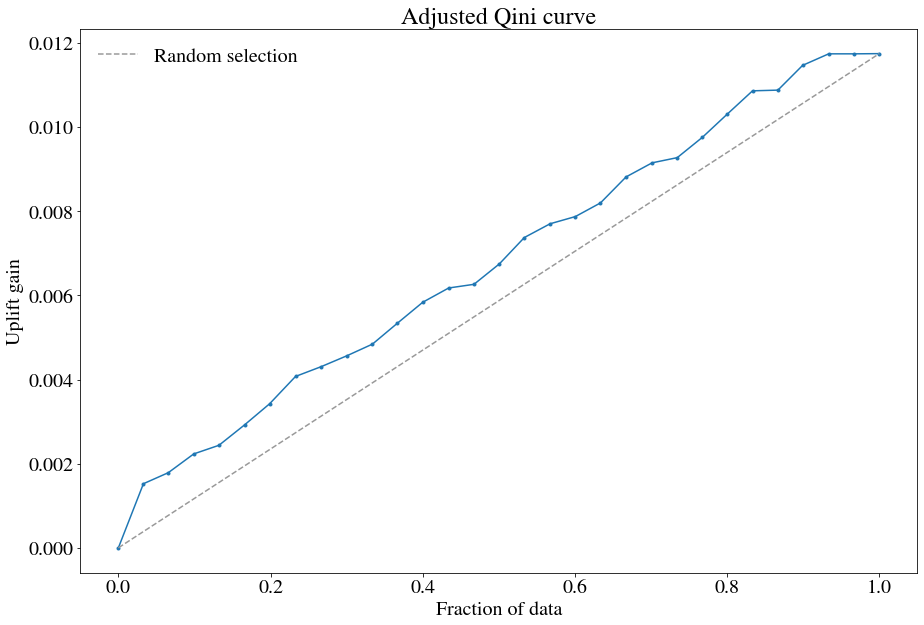

In [36]:
upev_S_cv_test = UpliftEval(treatment = test_X["treatment"], 
                  outcome = test_y["visit"], 
                  prediction = test_S_cv_tau["tau"], 
                  n_bins = 30)
upev_S_cv_test.plot(plot_type='aqini')